In [1]:
# import Serial libraries
import serial
import serial.tools.list_ports
import time
import numpy as np
import matplotlib.pyplot as plt
from cartpole_lib_python import *

In [72]:
# list serial ports
ports = list(serial.tools.list_ports.comports())
for p in ports:
    print(p)

/dev/ttyACM0 - Feather ESP32-S2 - TinyUSB CDC


In [73]:
serial_port = "/dev/ttyACM0"

In [74]:
start = time.time()

sp = cartpole_open_serial(serial_port)
data = cartpole_safe_read(sp)
cartpole_close_serial(sp)

end = time.time()

print("time elapsed", end-start, "seconds")
data

time elapsed 0.03032851219177246 seconds


[24.4281, 0.0, 7.84613, 0.18427, 4.45583, 0.02632, 0.0, 0.0]

In [80]:
control_frequency = 50 # Hz
control_period = 1/control_frequency
T = 2 # seconds
N = int(T*control_frequency) # number of control steps

states = np.zeros((N,4)) # initialize data array
controls = np.zeros((N,1)).astype(float) # initialize control array
control_input = np.zeros((N,2)).astype(float) # just for latency testing/debugging 
loop_time = []

elapsed_count = 0

# k_matrix = np.array([0.712575,  1216.79,  13.7152,  11025.4]) / 1000
k_matrix = np.array([0,  .58,  .6855,  .383])
# k_matrix = np.array([1.17157,  628.72,  28.3228,  452.99]) / 100
# k_matrix = np.array([0, 628.72, 0, 0]) / 100
# k_matrix = np.array([0, 628, 0, 352]) / 100
control_clamp = 5
# control_clamp = 0
mid_point = 0.25

sp = cartpole_open_serial(serial_port)
cartpole_busy_sleep(1, loop_start = time.time())

xg = np.array([mid_point, np.pi/2, 0, 0])

prev_x_vel = 0
prev_theta_vel = 0 
first = True

for i in range(N):
    # read the encoder data
    # save the encoder data
    # write a 0 torque command
    # wait for the next control period

    time_start = time.time()

    encoder_data = cartpole_safe_read(sp)
    states[i,0] = (encoder_data[0] * 0.01) # x pos
    states[i,1] = (encoder_data[2] % (2*np.pi)) # theta
    if abs(encoder_data[1] * 0.01 - prev_x_vel) > 0.1:
        states[i,2] = prev_x_vel
    else:
        states[i,2] = (encoder_data[1] * 0.01) # x vel
    if abs(encoder_data[3] - prev_theta_vel) > 2.5:
        states[i,3] = prev_theta_vel # theta vel 
    else:
        states[i,3] = encoder_data[3]
    
    if first:
        prev_x_vel = encoder_data[1] * 0.01
        prev_theta_vel = encoder_data[3]
        first = False
    else:
        prev_x_vel = states[i,2]
        prev_theta_vel = states[i,3]

    # state = np.array([[states[i,0]], [states[i,1]], [states[i,2]], [states[i,3]]])

    control_input[i,0] = encoder_data[6]
    control_input[i,1] = encoder_data[7]

    control = -k_matrix @ (states[i,:] - xg).T
    
    controls[i] = control

    # clamp control to be between -1 and 1
    if control > control_clamp:
        control = control_clamp
    elif control < -control_clamp:
        control = -control_clamp
    
    
    cartpole_write_motors(sp,control,0)

    elapsed_count += 1
    loop_time.append(time.time() - time_start)
    cartpole_busy_sleep(control_period, loop_start = time_start)

cartpole_write_motors(sp,0,0)
cartpole_close_serial(sp)

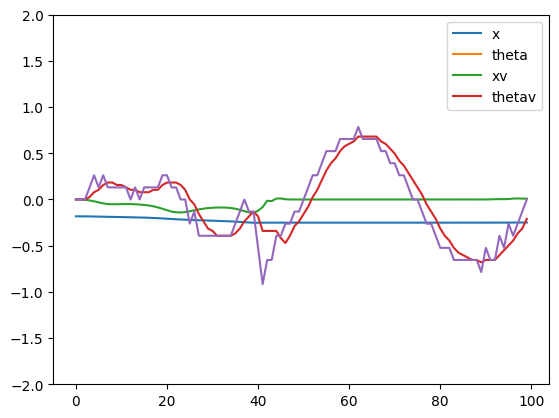

In [79]:
vels = np.zeros(N)
vels[0] = 0
for i in range(1,N):
    vels[i] = (states[i,1] - states[i-1,1]) / control_period
    
plt.plot((states-xg), label = "error")
plt.plot(vels)
plt.ylim([-2,2])
plt.legend(['x', 'theta', 'xv', 'thetav'])

(-5.0, 5.0)

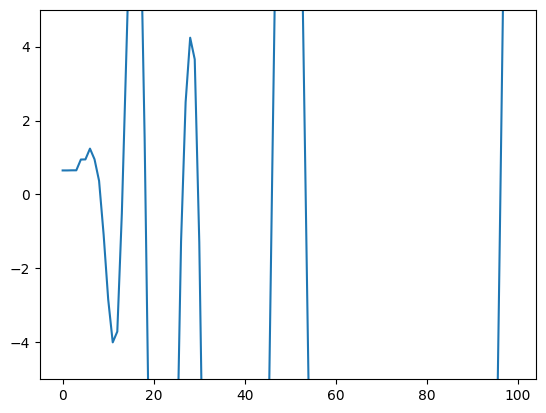

In [77]:
plt.plot(controls, label = "control")
plt.ylim([-control_clamp, control_clamp])

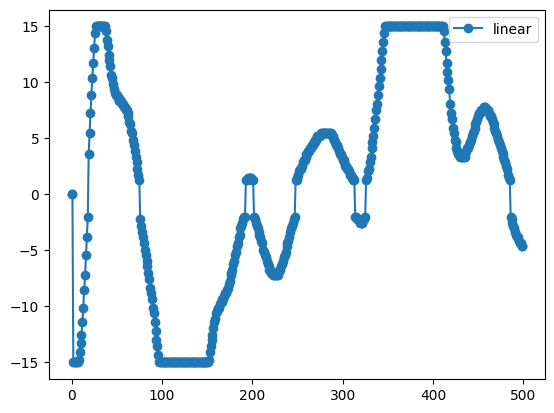

In [ ]:
# plot the data
# plt.plot(data[:,0], label = "linear")
# plt.plot(data[:,1], label = "shoulder")
# plt.plot(data[:,2], label = "elbow")
plt.plot(control_input[:,0] * 10, label = "linear", marker = "o") 
plt.legend()

plt.show()

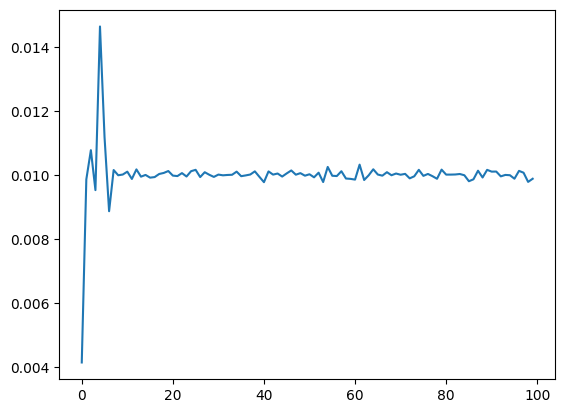

In [23]:
loop_time = np.array(loop_time)
plt.plot(loop_time)